In [1]:
import sys
!{sys.executable} -m pip install xmltodict
!nvidia-smi
import xmltodict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
gdrive = GoogleDrive(gauth)
def store_df_at_google_drive(fname, df):
    s = io.StringIO()
    df.to_csv(s)
    uploaded = gdrive.CreateFile({'title': fname, 'parents':[{'id': 'root'}]})
    uploaded.SetContentString(s.getvalue())
    uploaded.Upload()
    print('Uploaded file with ID {}'.format(uploaded.get('id')))

def load_df_at_google_drive(fname):
    file_list = gdrive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
    for file1 in file_list:
        if (file1['title'] == fname):
            downloaded = gdrive.CreateFile({'id': file1['id']})
            s = io.StringIO(downloaded.GetContentString())
            return pd.read_csv(s)
    
def load_dataset_from_google_drive(dir_id):
    files = []
    file_list = gdrive.ListFile({'q': "'{}' in parents".format(dir_id)}).GetList()
    for f in file_list:
        if f['title'] in ['Users.xml', 'Posts.xml','users_reduce.pkl', 'posts_reduce.pkl']:
            print('  Load file: {}'.format(f['title']))
            f_ = gdrive.CreateFile({'id': f['id']})
            f_.GetContentFile(f['title'])
            files.append(f['title'])
    return files

Thu Oct 24 06:01:49 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
files = load_dataset_from_google_drive('1Fp_7GDH_t7xfnU8aXeKrcBC54_nECOcu') 

  Load file: users_reduce.pkl
  Load file: posts_reduce.pkl


In [0]:
users_df = pd.read_pickle("{}.pkl".format('users_reduce'))   # shape: (992,110, 3)
posts_df = pd.read_pickle("{}.pkl".format('posts_reduce'))   # shape: (11,324,326, 10)

users_df.shape, posts_df.shape   # Total dataset

((992110, 3), (11324326, 10))

In [0]:
def getIthOfPosts(posts):
    print('getIthOfPosts')
    posts.sort_values(by=['OwnerUserId', 'CreationDate'], inplace=True)
    posts.reset_index(level=0, inplace=True)
    posts['id_owner_time'] = posts.index
    first_posts = posts.groupby('OwnerUserId')['id_owner_time'].min().to_frame()
    tmp = posts.join(first_posts, on='OwnerUserId', how='inner', lsuffix='F', rsuffix='P')
    posts['ith'] = tmp['id_owner_timeF'] - tmp['id_owner_timeP'] + 1
    posts = posts.drop(['id_owner_time'], axis=1)
    return posts

# You should extract the dataset for the period of the dataset: July 31, 2008 ~  July 31, 2012
start_time = pd.to_datetime('2008-07-31')
end_time = pd.to_datetime('2012-07-31')
end_time_2 = pd.to_datetime('2012-01-31')

posts_df = posts_df[(posts_df['CreationDate'] >= start_time) & (posts_df['CreationDate'] <= end_time)]
users_df = users_df[(users_df['CreationDate'] >= start_time) & (users_df['CreationDate'] <= end_time_2)]


posts_df = getIthOfPosts(posts_df)

getIthOfPosts


In [0]:
# Dataset in Task 1
#   Posts: Extract K posts of each user
#   Users: Extract users who post at least K

# k번째의 post를 가져온다.
def getTask1Posts(posts, K):
    tmp = posts[posts['ith'] == K]['OwnerUserId'].to_frame()
    tmp = tmp.set_index('OwnerUserId')
    tmp = posts[posts['OwnerUserId'].isin(tmp.index)]
    return tmp[tmp['ith'] <= K]

# k번째 이상의 user의 목록을 가져온다.
def getTask1Users(users, posts, K):
    users['num_posts'] = posts.groupby('OwnerUserId')['OwnerUserId'].count()
    users = users[users['num_posts'] >= K]
    return users


In [0]:
list_of_K = range(1, 21)
users_of_task1, posts_of_task1 = {}, {}


for K in list_of_K:
    posts_of_task1[K] = getTask1Posts(posts_df, K)
    users_of_task1[K] = getTask1Users(users_df, posts_df, K)

In [0]:
# Churn in Task 1
#   Churners: Users who did not post for at least 6 months from their K-th post 
#   Stayers:  Users who created at least one post within the 6 months from their K-th post

def prepareFeaturesTask1(users, posts, K):
    tmp = posts[posts['ith']==K]['OwnerUserId'].to_frame()
    tmp = tmp.set_index('OwnerUserId')
    posts = posts[posts['OwnerUserId'].isin(tmp.index)]

    posts_task = posts[posts['OwnerUserId'].isin(users.index)]
    posts_Kth_time = posts_task[posts_task['ith']==K]
    posts_Kth_time = posts_Kth_time.set_index('OwnerUserId')['CreationDate']
    posts_deadline = posts_Kth_time + pd.tseries.offsets.DateOffset(months=6)
    
    posts_stayer = posts_task[posts_task['ith'] > K].groupby('OwnerUserId')['CreationDate'].min().to_frame()
    posts_stayer = posts_stayer.merge(posts_deadline, on='OwnerUserId', how='left', suffixes=('_left', '_right'))
    
    posts_churner1 = posts_stayer[posts_stayer['CreationDate_left'] > posts_stayer['CreationDate_right']]
    posts_churner1['is_churn'] = 1
    posts_churner1 = posts_churner1[['is_churn']]
    posts_stayer = posts_stayer[posts_stayer['CreationDate_left'] <= posts_stayer['CreationDate_right']]
    posts_stayer['is_churn'] = 0    
    posts_stayer = posts_stayer[['is_churn']]
       
    posts_churner2 = posts_task[posts_task['ith'] >= K].groupby('OwnerUserId').count()
    posts_churner2 = posts_churner2[posts_churner2['CreationDate'] == 1][['CreationDate']]
    posts_churner2['is_churn'] = 1
    posts_churner2 = posts_churner2[['is_churn']]
    
    posts = pd.concat([posts_stayer, posts_churner1, posts_churner2])
    posts = posts.rename(columns={'OwnerUserId': 'Id'})
    users['is_churn'] = 0
    users.update(posts)
    return users

features_of_task1 = {}

for K in list_of_K:
    features_of_task1[K] = prepareFeaturesTask1(users_of_task1[K], posts_df, K)
  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/ind

In [0]:
# Dataset in Task 2
#   Users: Extract users who post at least 1
#   Posts: Extract posts which create before T day from the account creation of the owner

def getCreationDateOfOwner(users, posts):
    posts['DataframeIndex'] = posts.index
    posts['CreationDateOfOwner'] = posts.set_index('OwnerUserId')\
            .join(users, how='inner', rsuffix='OfOwner')\
            .set_index('DataframeIndex')['CreationDateOfOwner']
    posts = posts.drop(['DataframeIndex'], axis=1)
    return posts['CreationDateOfOwner']

  
def getTask2Posts(users, posts, T):
    if 'CreationDateOfUser' not in posts.columns:
        posts['CreationDateOfOwner'] = getCreationDateOfOwner(users, posts)
    observation_deadline = posts['CreationDateOfOwner'] + pd.offsets.Day(T)
    posts = posts[posts['CreationDate'] <= observation_deadline]
    return posts
  
def getTask2Users(users, posts):
    users['num_posts'] = posts.groupby('OwnerUserId')['OwnerUserId'].count()
    users = users[users['num_posts'] >= 1]
    return users
  
list_of_T = [7, 15, 30]
users_of_task2 = {}
posts_of_task2 = {}

for T in list_of_T:
    posts_of_task2[T] = getTask2Posts(users_df, posts_df, T)
    users_of_task2[T] = getTask2Users(users_df, posts_df)

In [0]:
# Churn in Task2
#   Churners: Users who did not post for at least 6 months from T days after account creation
#   Stayers:  Users who created at least one post within the 6 months from T days after account creation

def prepareFeaturesTask2(users, posts, T=30):
    if 'CreationDateOfUser' not in posts.columns:
        posts['CreationDateOfOwner'] = getCreationDateOfOwner(users, posts)
    users = getTask1Users(users, posts, K=1)
    observe_deadline = posts['CreationDateOfOwner'] + pd.offsets.Day(T)
    churn_deadline = observe_deadline + pd.tseries.offsets.DateOffset(months=6)
    posts_observed = posts[(posts['CreationDate'] <= observe_deadline) & (posts['CreationDate'] >= posts['CreationDateOfOwner'])]
    posts_after_observe = posts[(posts['CreationDate'] <= churn_deadline) & (posts['CreationDate'] > observe_deadline)]
    label_df = users.reindex((posts_observed.groupby('OwnerUserId')['OwnerUserId'].count() > 0).index)
    stayers = (posts_after_observe.groupby('OwnerUserId')['OwnerUserId'].count() > 0).index
    churners = list(set(label_df.index) - set(stayers))
    label_df['is_churn'] = 0.
    label_df.loc[churners, 'is_churn'] = 1.
    return label_df

features_of_task2 = {}
for T in list_of_T:
    features_of_task2[T] = prepareFeaturesTask2(users_of_task2[T], posts_df, T)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [0]:
# Temporal features 1: gap1
def getTimeGap1OfUser(users, posts):
    creation_date_user = users['CreationDate']
    creation_date_first_post = posts.groupby('OwnerUserId')['CreationDate'].min()
    return (creation_date_first_post - creation_date_user).dt.total_seconds()

In [0]:
# Temporal features 2: gapK

def getTimeGapkOfPosts(posts, k):
    date_1 = posts[posts['ith'] == (k-1)].sort_values('OwnerUserId')
    date_2 = posts[posts['ith'] == k].sort_values('OwnerUserId')
    date_2 = date_2.set_index('OwnerUserId')
    date_1 = date_1.set_index('OwnerUserId')
    result = (date_2['CreationDate'] - date_1['CreationDate']).dt.total_seconds() / 60  
    return result

In [0]:
# Temporal features 3: last_gap
def getTimeLastGapOfPosts(posts):
    last_posts = posts.groupby('OwnerUserId')['CreationDate'].max().to_frame()
    tmp = posts.join(last_posts, on='OwnerUserId', how='inner', lsuffix='F', rsuffix='P')
    tmp = tmp[tmp['CreationDateF'] < tmp['CreationDateP']].groupby('OwnerUserId')['CreationDateF'].max().to_frame()
    return (last_posts['CreationDate'] - tmp['CreationDateF']).dt.total_seconds() / 60

In [0]:
# Temporal features 4: time_since_last_post
def getTimeSinceLastPost(users, posts, T):
    last_post_date = posts.groupby('OwnerUserId')['CreationDate'].max()
    creation_after_T_days_date = users['CreationDate'] + pd.offsets.Day(T)
    return (creation_after_T_days_date - last_post_date).dt.total_seconds() / 60


In [0]:
# Temporal features 5: mean_gap
def getTimeMeanGap(posts):
    last_post_date = posts.groupby('OwnerUserId')['CreationDate'].max()
    first_post_date = posts.groupby('OwnerUserId')['CreationDate'].min()
    num_posts = posts.groupby('OwnerUserId')['CreationDate'].count()
    return (last_post_date - first_post_date).dt.total_seconds() / 60 / num_posts


In [0]:
# Extract temporal features for task1
for K in list_of_K:
    features_of_task1[K]['gap1'] = getTimeGap1OfUser(users_of_task1[K], posts_of_task1[K])
    for k in range(2, K+1):
        features_of_task1[K]['gap{}'.format(k)] = getTimeGapkOfPosts(posts_of_task1[K], k)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

K=1


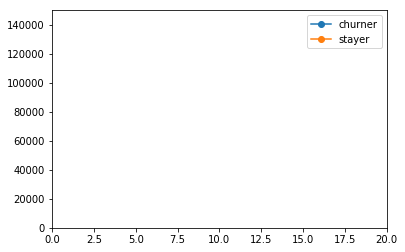

K=2


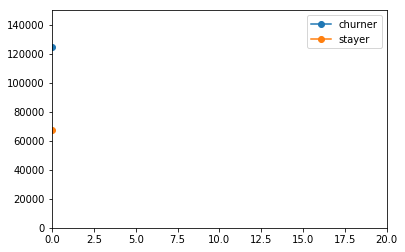

K=3


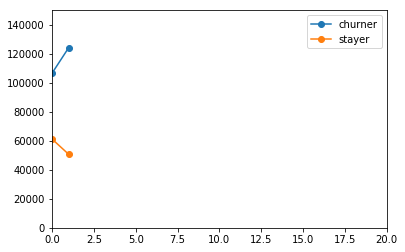

K=4


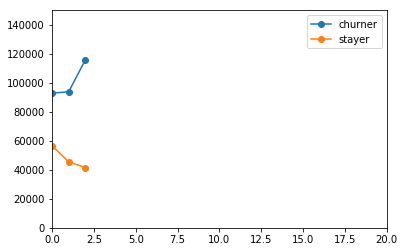

K=5


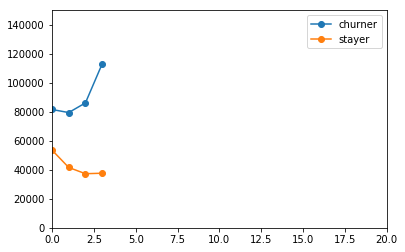

K=6


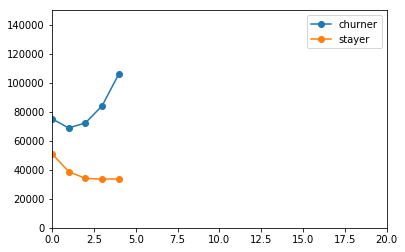

K=7


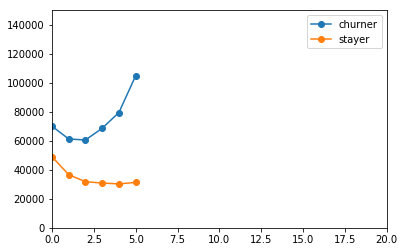

K=8


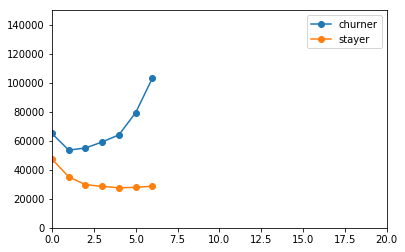

K=9


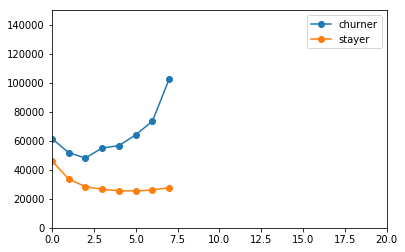

K=10


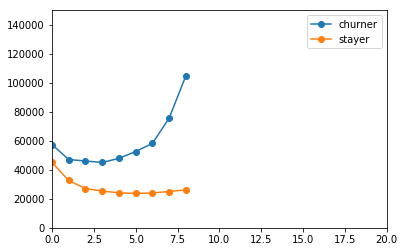

K=11


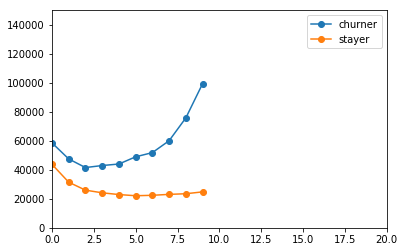

K=12


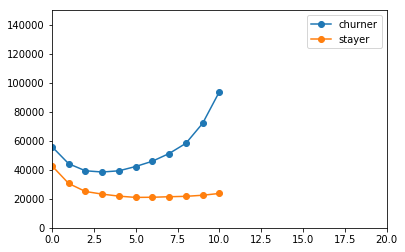

K=13


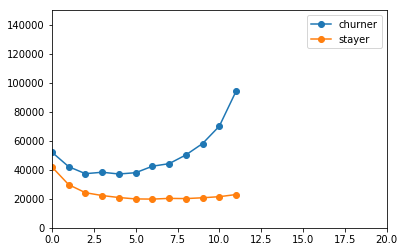

K=14


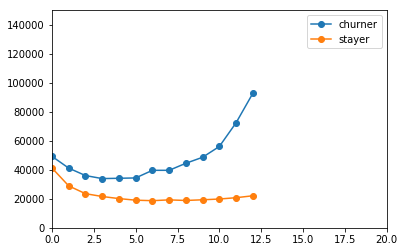

K=15


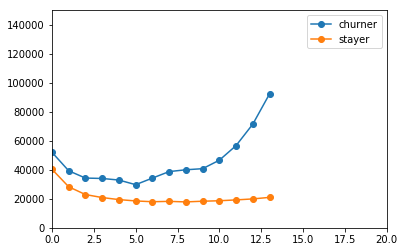

K=16


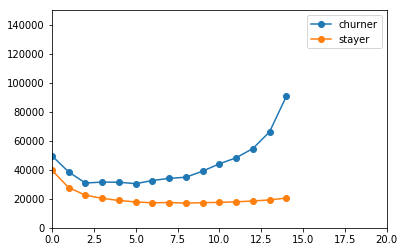

K=17


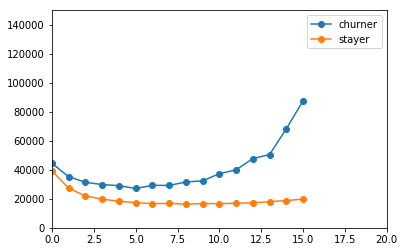

K=18


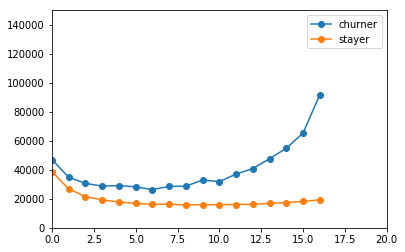

K=19


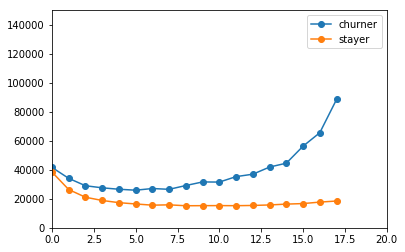

K=20


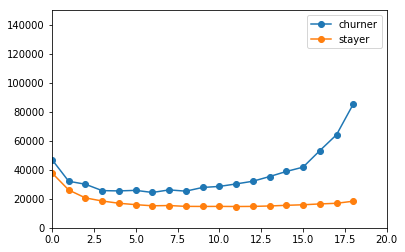

In [0]:
# Figure 2: Gap between posts
#    For a user who churns, gap between consecutive posts keeps increasing. 
#    Gaps for those who stay are much lower, and stabilize around 20,000 minutes,
#    indicating routine posting activity in every ≈2 weeks.
clist = []
slist = []
for K in list_of_K:
    subgroup = features_of_task1[K]
    churners_gap = []
    stayers_gap = []
    for i in range(2, K+1):
        gapK = 'gap{}'.format(i)
        sum_gapK = list(subgroup.groupby('is_churn')[gapK].sum())
        count_gapK = list(subgroup.groupby('is_churn')[gapK].count())
        if len(sum_gapK) < 2:
            break
        churners_gap.append(sum_gapK[1] / count_gapK[1])
        stayers_gap.append(sum_gapK[0] / count_gapK[0])

    clist.append(churners_gap)
    slist.append(stayers_gap)
    
    print("K={}".format(K))
    plt.plot(churners_gap, '-o', label='churner')
    plt.plot(stayers_gap, '-o', label='stayer')
    plt.legend()
    plt.axis((0,20,0,15e4))
    plt.show()

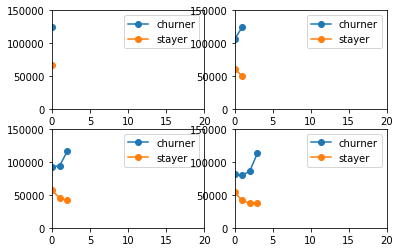

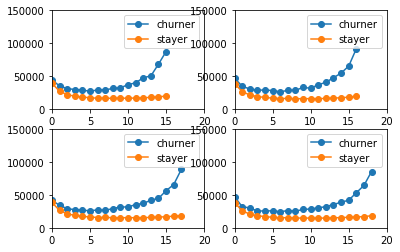

In [0]:
fig = plt.figure()
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)
axlist = [ax1, ax2, ax3, ax4]
for c, s, ax in zip(clist[1:], slist[1:], axlist):
    ax.plot(c, '-o', label='churner')
    ax.plot(s, '-o', label='stayer')
    ax.legend()
    ax.axis((0,20,0,15e4))
plt.show()

fig = plt.figure()
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)
axlist = [ax1, ax2, ax3, ax4]
for c, s, ax in zip(clist[-4:], slist[-4:], axlist):
    ax.plot(c, '-o', label='churner')
    ax.plot(s, '-o', label='stayer')
    ax.legend()
    ax.axis((0,20,0,15e4))
plt.show()

In [0]:
# Extract temporal features for task2
for T in list_of_T:
    users, posts = users_of_task2[T], posts_of_task2[T]
    features_of_task2[T]['gap1'] = getTimeGap1OfUser(users, posts)
    features_of_task2[T]['last_gap'] = getTimeLastGapOfPosts(posts).fillna(features_of_task2[T]['gap1'])
    #features_of_task2[T]['last_gap'] = getTimeLastGapOfPosts(posts).fillna(0)
    features_of_task2[T]['time_since_last_post'] = getTimeSinceLastPost(users, posts, T)
    features_of_task2[T]['mean_gap'] = getTimeMeanGap(posts)
  


In [0]:
# Frequency features 1: num_answers
# Frequency features 2: num_questions
def getNumAnswers(posts):
    answers = posts[posts['PostTypeId'] == 2]
    return answers.groupby('OwnerUserId')['OwnerUserId'].count()

def getNumQuestions(posts):
    questions = posts[posts['PostTypeId'] == 1]
    return questions.groupby('OwnerUserId')['OwnerUserId'].count()


In [0]:
# Frequency features 3: ans_ques_ratio
def getAnsQuesRatio(num_answers, num_questions):
    # Use Laplace Smoothing
    return num_answers / (num_questions + 1)


In [0]:
# Frequency features 4: num_posts
def getNumPosts(posts):
    return posts.groupby('OwnerUserId')['OwnerUserId'].count().astype('float')

In [0]:
# Extract frequency features of task1
for K in list_of_K:
    users, posts = users_of_task1[K], posts_of_task1[K]
    features_of_task1[K]['num_answers'] = getNumAnswers(posts)
    features_of_task1[K]['num_questions'] = getNumQuestions(posts)
    features_of_task1[K] = features_of_task1[K].fillna({'num_answers':0, 'num_questions':0})
    features_of_task1[K]['ans_que_ratio'] = \
        getAnsQuesRatio(features_of_task1[K]['num_answers'], features_of_task1[K]['num_questions'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [0]:
# Extract frequency features of task2
for T in list_of_T:
    users, posts = users_of_task2[T], posts_of_task2[T]
    features_of_task2[T]['num_answers'] = getNumAnswers(posts)
    features_of_task2[T]['num_questions'] = getNumQuestions(posts)
    features_of_task2[T] = features_of_task2[T].fillna({'num_answers':0,'num_questions':0})
    features_of_task2[T]['ans_que_ratio'] = \
        getAnsQuesRatio(features_of_task2[T]['num_answers'], features_of_task2[T]['num_questions'])
    features_of_task2[T]['num_posts'] = getNumPosts(posts)

# Answers vs Churn probability


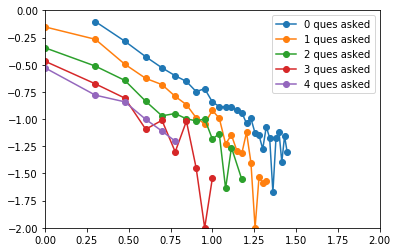

# Answers vs Churn probability


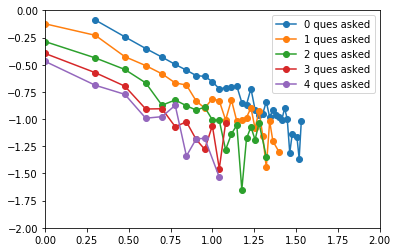

# Answers vs Churn probability


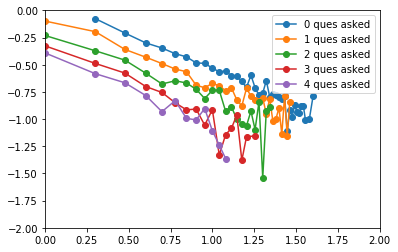

In [0]:
# Figure 3: # Answers vs Churn probability
#    The probability of churning for a user decreases the more answers s/he provides.
#    It is even lower if s/he asks more questions alongside.

min_num_users = 50
for T in list_of_T:
    task2 = features_of_task2[T]
    for num_que_ask in range(5):
        subgroup = task2[task2['num_questions'] == num_que_ask]
        churn_probs = []
        num_answers = list(set(subgroup['num_answers']))
        num_answers.sort()
        for num_ans in num_answers:
            subsubgroup = subgroup[subgroup['num_answers'] == num_ans]
            prob = sum(subsubgroup['is_churn']) / subsubgroup.shape[0]
            if subsubgroup.shape[0] >= min_num_users:
                churn_probs.append((num_ans, prob))

        plt.plot([np.log10(x[0]+1) for x in churn_probs],
                 [np.log10(x[1]+0.01) for x in churn_probs],
                 '-o',
                 label='{} ques asked'.format(num_que_ask))
    print("# Answers vs Churn probability")
    plt.legend()
    plt.axis((0,2,-2,0))
    plt.show()

In [0]:
# Quality features 1 : ans_score
def getScoreOfAnswer(posts):
    answers = posts[posts['PostTypeId'] == 2]
    temp = answers.groupby('Id')['Score'].mean()
    answers = answers.join(temp, on='Id', how='inner', lsuffix='L', rsuffix='R')
    return answers.groupby('OwnerUserId')['ScoreR'].mean()

In [0]:
# Quality features 2 : que_score
def getScoreOfQuestion(posts):
    questions = posts[posts['PostTypeId'] == 1]
    temp = questions.groupby('Id')['Score'].mean()
    questions = questions.join(temp, on='Id', how='inner', lsuffix='L', rsuffix='R')
    return questions.groupby('OwnerUserId')['ScoreR'].mean()

In [0]:
# Extract quality features of task 1
posts = pd.DataFrame()
for K in list_of_K:
    print("Extract quality features of task1(K=",K,")")
    posts = pd.concat([posts, posts_of_task1[K]])
    #users, posts = users_of_task1[K], posts_of_task1[K]
    features_of_task1[K]['ans_score'] = getScoreOfAnswer(posts)
    features_of_task1[K]['que_score'] = getScoreOfQuestion(posts)

Extract quality features of task1(K= 1 )
Extract quality features of task1(K= 2 )
Extract quality features of task1(K= 3 )
Extract quality features of task1(K= 4 )
Extract quality features of task1(K= 5 )
Extract quality features of task1(K= 6 )
Extract quality features of task1(K= 7 )
Extract quality features of task1(K= 8 )
Extract quality features of task1(K= 9 )
Extract quality features of task1(K= 10 )
Extract quality features of task1(K= 11 )
Extract quality features of task1(K= 12 )
Extract quality features of task1(K= 13 )
Extract quality features of task1(K= 14 )
Extract quality features of task1(K= 15 )
Extract quality features of task1(K= 16 )
Extract quality features of task1(K= 17 )
Extract quality features of task1(K= 18 )
Extract quality features of task1(K= 19 )
Extract quality features of task1(K= 20 )


In [0]:
# Extract quality features of task 2
for T in list_of_T:
    print("Extract quality features of task2(T=)",T,")")
    posts = posts_of_task2[T]
    features_of_task2[T]['ans_score'] = getScoreOfAnswer(posts)
    features_of_task2[T]['que_score'] = getScoreOfQuestion(posts)

Extract quality features of task2(T=) 7 )
Extract quality features of task2(T=) 15 )
Extract quality features of task2(T=) 30 )


In [0]:
# Consistency features 1 : ans_stddev
def getStddevOfAnswer(posts):
    answers = posts[posts['PostTypeId'] == 2]
    return answers.groupby('OwnerUserId')['Score'].std()

In [0]:
# Consistency features 2 : que_stddev
def getStddevOfQuestion(posts):
    questions = posts[posts['PostTypeId'] == 1]
    return questions.groupby('OwnerUserId')['Score'].std()

In [0]:
# Extract Consistency features of task 1
posts = pd.DataFrame()
for K in list_of_K:
    print("Extract consistency features of task1(K=",K,")")
    posts = pd.concat([posts, posts_of_task1[K]])
    features_of_task1[K]['ans_stddev'] = getScoreOfAnswer(posts)
    features_of_task1[K]['que_stddev'] = getScoreOfQuestion(posts)

Extract consistency features of task1(K= 1 )
Extract consistency features of task1(K= 2 )
Extract consistency features of task1(K= 3 )
Extract consistency features of task1(K= 4 )
Extract consistency features of task1(K= 5 )
Extract consistency features of task1(K= 6 )
Extract consistency features of task1(K= 7 )
Extract consistency features of task1(K= 8 )
Extract consistency features of task1(K= 9 )
Extract consistency features of task1(K= 10 )
Extract consistency features of task1(K= 11 )
Extract consistency features of task1(K= 12 )
Extract consistency features of task1(K= 13 )
Extract consistency features of task1(K= 14 )
Extract consistency features of task1(K= 15 )
Extract consistency features of task1(K= 16 )
Extract consistency features of task1(K= 17 )
Extract consistency features of task1(K= 18 )
Extract consistency features of task1(K= 19 )
Extract consistency features of task1(K= 20 )


In [0]:
# Extract Consistency features of task 2
for T in list_of_T:
    print("Extract consistency features of task2(T=)",T,")")
    posts = posts_of_task2[T]
    features_of_task2[T]['ans_stddev'] = getScoreOfAnswer(posts)
    features_of_task2[T]['que_stddev'] = getScoreOfQuestion(posts)

Extract consistency features of task2(T=) 7 )
Extract consistency features of task2(T=) 15 )
Extract consistency features of task2(T=) 30 )


In [0]:
def getAnsweringSpeed(users, posts, all_posts):
    def inverse_num(x):
        if x == np.nan or x == 0:
            return 0
        else:
            return 1 / x
    answers = posts[posts['PostTypeId'] == 2]
    all_questions = all_posts[all_posts['PostTypeId'] == 1]
    #print('check', answers.columns)
    #print('all', all_questions.columns)
    answers = answers.merge(all_questions, left_on='ParentId', right_on='Id',
                            how='left', suffixes=('A', 'Q'))
    #print(answers.columns)
    answers['answering_speed'] = (answers['CreationDateA'] - answers['CreationDateQ']).dt.total_seconds() / 60
    return answers.groupby('OwnerUserIdA')['answering_speed'].mean().apply(inverse_num)

In [0]:
# Extract Speed features of task 1
for K in list_of_K:
    print("Extract speed features of task1(K=",K,")")
    users_of_task1[K]['answering_speed'] = getAnsweringSpeed(users_of_task1[K], posts_of_task1[K], posts_df)

Extract speed features of task1(K= 1 )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Extract speed features of task1(K= 2 )
Extract speed features of task1(K= 3 )
Extract speed features of task1(K= 4 )
Extract speed features of task1(K= 5 )
Extract speed features of task1(K= 6 )
Extract speed features of task1(K= 7 )
Extract speed features of task1(K= 8 )
Extract speed features of task1(K= 9 )
Extract speed features of task1(K= 10 )
Extract speed features of task1(K= 11 )
Extract speed features of task1(K= 12 )
Extract speed features of task1(K= 13 )
Extract speed features of task1(K= 14 )
Extract speed features of task1(K= 15 )
Extract speed features of task1(K= 16 )
Extract speed features of task1(K= 17 )
Extract speed features of task1(K= 18 )
Extract speed features of task1(K= 19 )
Extract speed features of task1(K= 20 )


In [0]:
# Extract Speed features of task 1
for T in list_of_T:
    print("Extract speed features of task2(T=",T,")")
    users_of_task2[T]['answering_speed'] = getAnsweringSpeed(users_of_task2[T], posts_of_task2[T], posts_df)

Extract speed features of task2(T= 7 )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Extract speed features of task2(T= 15 )
Extract speed features of task2(T= 30 )


In [0]:
# Gratitude features 1 : ans_comments
def getAnswerComment(posts):
    posts = posts[posts['PostTypeId'] == 2]
    return posts.groupby('OwnerUserId')['CommentCount'].mean()

In [0]:
# Gratitude features 2 : ans_comments
def getQuestionComment(posts):
    posts = posts[posts['PostTypeId'] == 1]
    return posts.groupby('OwnerUserId')['CommentCount'].mean()

In [0]:
# Extract Gratitude features of task 1
posts = pd.DataFrame()
for K in list_of_K:
    print("Extract Gratitude features of task1(K=",K,")")
    posts = pd.concat([posts, posts_of_task1[K]])
    users_of_task1[K]['ans_comments'] = getAnswerComment(posts)
    users_of_task1[K]['que_comments'] = getQuestionComment(posts)

Extract Gratitude features of task1(K= 1 )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Extract Gratitude features of task1(K= 2 )
Extract Gratitude features of task1(K= 3 )
Extract Gratitude features of task1(K= 4 )
Extract Gratitude features of task1(K= 5 )
Extract Gratitude features of task1(K= 6 )
Extract Gratitude features of task1(K= 7 )
Extract Gratitude features of task1(K= 8 )
Extract Gratitude features of task1(K= 9 )
Extract Gratitude features of task1(K= 10 )
Extract Gratitude features of task1(K= 11 )
Extract Gratitude features of task1(K= 12 )
Extract Gratitude features of task1(K= 13 )
Extract Gratitude features of task1(K= 14 )
Extract Gratitude features of task1(K= 15 )
Extract Gratitude features of task1(K= 16 )
Extract Gratitude features of task1(K= 17 )
Extract Gratitude features of task1(K= 18 )
Extract Gratitude features of task1(K= 19 )
Extract Gratitude features of task1(K= 20 )


In [0]:
# Extract Gratitude features of task 2
for T in list_of_T:
    print("Extract Gratitude features of task2(T=",T,")")
    users_of_task2[T]['ans_comments'] = getAnswerComment(posts_of_task2[T])
    users_of_task2[T]['que_comments'] = getQuestionComment(posts_of_task2[T])

Extract Gratitude features of task2(T= 7 )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Extract Gratitude features of task2(T= 15 )
Extract Gratitude features of task2(T= 30 )


In [0]:
# Content features 1 : ans_length
def getAnswerLength(posts):
    posts = posts[posts['PostTypeId'] == 2]
    return posts.groupby('OwnerUserId')['BodyWordNum'].mean()

# Content features 2 : que_length
def getQuestionLength(posts):
    posts = posts[posts['PostTypeId'] == 1]
    return posts.groupby('OwnerUserId')['BodyWordNum'].mean()

# Extract Content features of task 1
posts = pd.DataFrame()
for K in list_of_K:
    print("Extract Content features of task1(K=",K,")")
    posts = pd.concat([posts, posts_of_task1[K]])
    users_of_task1[K]['que_length'] = getQuestionLength(posts)
    users_of_task1[K]['ans_length'] = getAnswerLength(posts)
    
# Extract Content features of task 2
for T in list_of_T:
    print("Extract Content features of task2(T=",T,")")
    users_of_task2[T]['que_length'] = getQuestionLength(posts_of_task2[T])
    users_of_task2[T]['ans_length'] = getAnswerLength(posts_of_task2[T])

Extract Content features of task1(K= 1 )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


Extract Content features of task1(K= 2 )
Extract Content features of task1(K= 3 )
Extract Content features of task1(K= 4 )
Extract Content features of task1(K= 5 )
Extract Content features of task1(K= 6 )
Extract Content features of task1(K= 7 )
Extract Content features of task1(K= 8 )
Extract Content features of task1(K= 9 )
Extract Content features of task1(K= 10 )
Extract Content features of task1(K= 11 )
Extract Content features of task1(K= 12 )
Extract Content features of task1(K= 13 )
Extract Content features of task1(K= 14 )
Extract Content features of task1(K= 15 )
Extract Content features of task1(K= 16 )
Extract Content features of task1(K= 17 )
Extract Content features of task1(K= 18 )
Extract Content features of task1(K= 19 )
Extract Content features of task1(K= 20 )
Extract Content features of task2(T= 7 )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Extract Content features of task2(T= 15 )
Extract Content features of task2(T= 30 )


In [0]:
# Competitiveness features 1 : relative_rank_pos
def getRelRankPos(posts, all_posts):
    def num_answers(X):
        return group_count[X]
    
    posts = posts[posts['PostTypeId'] == 2]
    all_questions = all_posts[all_posts['PostTypeId'] == 1]
    all_answers = all_posts[all_posts['PostTypeId'] == 2]
    
    all_answers['rank'] = all_answers.sort_values(['Score'], ascending=False)\
        .groupby('ParentId', as_index=False).cumcount()
    group_count = all_answers.groupby('ParentId')['ParentId'].count()
    all_answers['num_answers'] = all_answers['ParentId'].apply(num_answers)
    all_answers['relative_rank_pos'] = all_answers['num_answers'] / (all_answers['rank'] + 1)
    posts = posts.merge(all_answers, on='Id', how='left',\
                                              suffixes=('_left', '_right'))
    #print(posts.columns)
    #print(temp)
    #print(temp.index)
    #posts_stayer.merge(posts_deadline, on='OwnerUserId', how='left', suffixes=('_left', '_right'))
    #print(temp)
    return posts.groupby('OwnerUserId_left')['relative_rank_pos'].mean()

for K in list_of_K:
    print("Extract relative features of task1(K=",K,")")
    posts_of_task1[K]['relative_rank_pos'] = getRelRankPos(posts_of_task1[K], posts_df)
    
for T in list_of_T:
    print("Extract relative features of task1(T=",T,")")
    posts_of_task2[T]['relative_rank_pos'] = getRelRankPos(posts_of_task2[T], posts_df)

Extract relative features of task1(K= 1 )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

Extract relative features of task1(K= 2 )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

Extract relative features of task1(K= 3 )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

Extract relative features of task1(K= 4 )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

Extract relative features of task1(K= 5 )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

Extract relative features of task1(K= 6 )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

Extract relative features of task1(K= 7 )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

Extract relative features of task1(K= 8 )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

Extract relative features of task1(K= 9 )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

Extract relative features of task1(K= 10 )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

Extract relative features of task1(K= 11 )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

Extract relative features of task1(K= 12 )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

Extract relative features of task1(K= 13 )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

Extract relative features of task1(K= 14 )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

Extract relative features of task1(K= 15 )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

Extract relative features of task1(K= 16 )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

Extract relative features of task1(K= 17 )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

Extract relative features of task1(K= 18 )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

Extract relative features of task1(K= 19 )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

Extract relative features of task1(K= 20 )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

Extract relative features of task1(T= 7 )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

Extract relative features of task1(T= 15 )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

Extract relative features of task1(T= 30 )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [0]:
# For the fast extraction, prepare questions x answers
def preprocessForKnowledgeFeaturesForTask1(users, posts, all_posts):
    answers = posts[posts['PostTypeId'] == 2]
    questions = posts[posts['PostTypeId'] == 1]
    all_answers = all_posts[all_posts['PostTypeId'] == 2]
    all_questions = all_posts[all_posts['PostTypeId'] == 1]

    qnta = all_answers.set_index('ParentId')\
        .join(questions.set_index('Id', drop=False), how='inner',\
              lsuffix='A', rsuffix='Q')
    tqna = answers.set_index('ParentId')\
        .join(all_questions.set_index('Id', drop=False), how='inner',\
              lsuffix='A', rsuffix='Q')
    return answers, questions, qnta, tqna

In [0]:
# For the fast extraction, prepare questions x answers
def preprocessForKnowledgeFeaturesForTask2(users, posts):
    answers = posts[posts['PostTypeId'] == 2]
    questions = posts[posts['PostTypeId'] == 1]
    qna = answers\
        .set_index('ParentId').join(questions.set_index('Id', drop=False),\
                                    how='inner',\
                                    lsuffix='A', rsuffix='Q')
    return answers, questions, qna, qna

In [0]:
# Knowledge features 1: accepted_answerer_rep
def getRepOfAcceptedAnswerer(users, answers, questions, qnta, tqna):
    reputations = users.loc[:, ['Reputation']]
    rep_accepted_ans = qnta[qnta['AcceptedAnswerIdQ'] == qnta['IdA']]\
        .set_index('OwnerUserIdA')\
        .join(reputations, how='inner')\
        .groupby('OwnerUserIdQ')['Reputation'].mean()
    return rep_accepted_ans


In [0]:
# Knowledge features 2: max_rep_answerer 
def getMaxRepAmongAnswerer(users, answers, questions, qnta, tqna):
    reputations = users.loc[:, ['Reputation']]
    rep_max_ans = qnta.set_index('OwnerUserIdA')\
        .join(reputations, how='inner')\
        .groupby('OwnerUserIdQ')['Reputation'].max()
    return rep_max_ans


In [0]:
# Knowledge features 3: num_que_answered
def getNumQueAnswered(users, answers, questions, qnta, tqna):
    # number of questions posted by the user that got answered
    #questions = posts[posts['PostTypeId'] == 1]
    answered_questions = questions[questions['AnswerCount'] > 0]
    return answered_questions.groupby('OwnerUserId')['AnswerCount'].count()


In [0]:
# Knowledge features 4: time_for_first_ans
def getTimeForFirstAns(users, answers, questions, qnta, tqna):
    tmp =  qnta[qnta['CreationDateQ'] < qnta['CreationDateA']]
    tmp['time_for_ans'] = (tmp['CreationDateA'] - tmp['CreationDateQ']).dt.total_seconds() / 60
    questions['time_for_first_ans'] = tmp.groupby(by=tmp.index)['time_for_ans'].min()
    return questions.groupby('OwnerUserId')['time_for_first_ans'].mean()


In [0]:
# Knowledge features 5: rep_questioner
def getAvgRepOfQuestioner(users, answers, questions, qnta, tqna):
    # Avg. reputation of the user whose question was answered
    reputations = users.loc[:, ['Reputation']]
    rep_accepted_ans = tqna.set_index('OwnerUserIdQ')\
        .join(reputations, how='inner')\
        .groupby('OwnerUserIdA')['Reputation'].mean()
    return rep_accepted_ans


In [0]:
# Knowledge features 6: rep_answerers
def getAvgRepOfAnswerer(users, answers, questions, qnta, tqna):
    # Avg. reputation of the users who answered the question
    reputations = users.loc[:, ['Reputation']]
    rep_accepted_ans = qnta.set_index('OwnerUserIdA')\
        .join(reputations, how='inner')\
        .groupby('OwnerUserIdQ')['Reputation'].mean()
    return rep_accepted_ans


In [0]:
# Knowledge features 7: rep_co_answerers
def getAvgRepOfCoAnswerer(users, answers, questions, qnta, tqna):
    reputations = users.loc[:, ['Reputation']]    
    rep_ans = answers.set_index('OwnerUserId')\
        .join(reputations, how='inner')\
        .set_index('ParentId')\
        .join(questions, how='inner', lsuffix='A', rsuffix='Q')
    avg_rep_ans = rep_ans.groupby(by=rep_ans.index)['Reputation'].mean()
    rep_co_answerer = answers.set_index('ParentId')\
        .join(avg_rep_ans, how='inner')\
        .set_index('OwnerUserId')
    return rep_co_answerer.groupby(by=rep_co_answerer.index)['Reputation'].mean()


In [0]:
# Knowledge features 8: num_answers_recvd
def getAvgNumAnsReceived(users, answers, questions, qnta, tqna):
    #questions = posts[posts['PostTypeId'] == 1]
    return questions.fillna({'AnswerCount': 0}).groupby('OwnerUserId')['AnswerCount'].mean()


In [0]:
# Extract knowledge features of task 1
for K in list_of_K:
    print("Extract knowledge features of task1(K=",K,")")
    users, posts = users_of_task1[K], posts_of_task1[K]
    answers, questions, qnta, tqna = preprocessForKnowledgeFeaturesForTask1(users, posts, posts_df)
    features_of_task1[K]['accepted_answerer_rep'] = getRepOfAcceptedAnswerer(users, answers, questions,  qnta, tqna)
    features_of_task1[K]['max_rep_answerer'] = getMaxRepAmongAnswerer(users, answers, questions,  qnta, tqna)
    features_of_task1[K]['num_que_answered'] = getNumQueAnswered(users, answers, questions,  qnta, tqna)
    features_of_task1[K]['time_for_first_ans'] = getTimeForFirstAns(users, answers, questions, qnta, tqna)
    features_of_task1[K]['rep_questioner'] = getAvgRepOfQuestioner(users, answers, questions, qnta, tqna)
    features_of_task1[K]['rep_answerers'] = getAvgRepOfAnswerer(users, answers, questions, qnta, tqna)
    features_of_task1[K]['rep_co_answerers'] = getAvgRepOfCoAnswerer(users, answers, questions, qnta, tqna)
    features_of_task1[K]['num_answers_recvd'] = getAvgNumAnsReceived(users, answers, questions, qnta, tqna)

Extract knowledge features of task1(K= 1 )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Extract knowledge features of task1(K= 2 )
Extract knowledge features of task1(K= 3 )
Extract knowledge features of task1(K= 4 )
Extract knowledge features of task1(K= 5 )
Extract knowledge features of task1(K= 6 )
Extract knowledge features of task1(K= 7 )
Extract knowledge features of task1(K= 8 )
Extract knowledge features of task1(K= 9 )
Extract knowledge features of task1(K= 10 )
Extract knowledge features of task1(K= 11 )
Extract knowledge features of task1(K= 12 )
Extract knowledge features of task1(K= 13 )
Extract knowledge features of task1(K= 14 )
Extract knowledge features of task1(K= 15 )
Extract knowledge features of task1(K= 16 )
Extract knowledge features of task1(K= 17 )
Extract knowledge features of task1(K= 18 )
Extract knowledge features of task1(K= 19 )
Extract knowledge features of task1(K= 20 )


In [0]:
for T in list_of_T:
    print("Extract knowledge features of task2(T=)",T,")")
    users, posts = users_of_task2[T], posts_of_task2[T]
    answers, questions, qna, qna1 = preprocessForKnowledgeFeaturesForTask2(users, posts)
    features_of_task2[T]['accepted_answerer_rep'] = getRepOfAcceptedAnswerer(users, answers, questions, qna, qna1)
    features_of_task2[T]['max_rep_answerer'] = getMaxRepAmongAnswerer(users, answers, questions, qna, qna1)
    features_of_task2[T]['num_que_answered'] = getNumQueAnswered(users, answers, questions, qna, qna1)
    features_of_task2[T]['time_for_first_ans'] = getTimeForFirstAns(users, answers, questions, qna, qna1)
    features_of_task2[T]['rep_questioner'] = getAvgRepOfQuestioner(users, answers, questions, qna, qna1)
    features_of_task2[T]['rep_answerers'] = getAvgRepOfAnswerer(users, answers, questions, qna, qna1)
    features_of_task2[T]['rep_co_answerers'] = getAvgRepOfCoAnswerer(users, answers, questions, qna, qna1)
    features_of_task2[T]['num_answers_recvd'] = getAvgNumAnsReceived(users, answers, questions, qna, qna1)

Extract knowledge features of task2(T=) 7 )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Extract knowledge features of task2(T=) 15 )
Extract knowledge features of task2(T=) 30 )


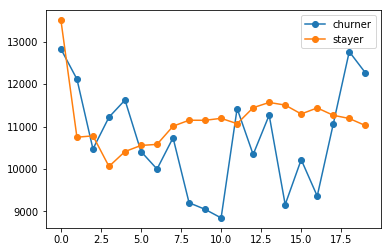

In [0]:
# Figure 4: K vs Time taken for the first answer to arrive
#  The more the time taken for a user to receive an answer, 
#  the lesser the satisfaction level and the more the chances of churning.
churners_time = []
stayers_time = []
for K in list_of_K:
    subgroup = features_of_task1[K]
    churners = subgroup[subgroup['is_churn'] == 1] 
    stayers = subgroup[subgroup['is_churn'] == 0]
    churners
    churners_time.append(churners['time_for_first_ans'].dropna().mean())
    stayers_time.append(stayers['time_for_first_ans'].dropna().mean())
    

plt.plot(churners_time, '-o', label='churner')
plt.plot(stayers_time, '-o', label='stayer')
plt.legend()
# plt.axis((0,20,8e3,22e3))
plt.show()

In [0]:
# Store the whole features of task1 to Google Drive
for K in list_of_K:
    store_df_at_google_drive('task1p_{}posts_features.csv'.format(K), features_of_task1[K])
    #features_of_task1[K].to_pickle('task1_{}posts_important_features.pkl'.format(K))
    #features_of_task1[K].to_csv('task1_{}posts_important_features.csv'.format(K))

Uploaded file with ID 1N-4F9QSHiwmP91ZAwwyb9b8w-H3nm0fO
Uploaded file with ID 1v8NBzP8Z-pxl1R8y5QgHzkj0MFCVz4pw
Uploaded file with ID 1varJr0PLvbhGxYaiV1-do9chBK2ijUIX
Uploaded file with ID 1aB9qzxCQU_nIDVnSsGQiQQ6SmJWzEpxK
Uploaded file with ID 10zES8eJH6r4ombgELznl943Tqzu9HxXQ
Uploaded file with ID 1cTk2mU4QiMr1ERnFARWe1xpFXkn518Ja
Uploaded file with ID 1n4YD09Srw0oFikmXisQH_OA4dk1F0www
Uploaded file with ID 1KcsOAwjGYMjeEGYxcQ70IgkteNLH5TVm
Uploaded file with ID 13ma3dJAO8Tv_5XoW4XuI3a2Tt6CXcZKl
Uploaded file with ID 1SC2y-J1z-DahZgE6hi-DY6_q4zy3DZhJ
Uploaded file with ID 1Tcq_nZ2cx6x-xbILmPS6_y6IvWY3DZCA
Uploaded file with ID 1nu6D4B8nALokNUy18YtVVvsvi8ZHOeLG
Uploaded file with ID 1G1yYSCQDrvOJeFMRxV7_eeiyQTWvlvXT
Uploaded file with ID 1ZnWok9JFPFoIdKEq5f-BFucBAb6I5oz5
Uploaded file with ID 1yDose4_BboToevQdWvxyBoL5108ql8dm
Uploaded file with ID 1k8FskTA-F-QhprAUQ8zYNsokSpeRgLf4
Uploaded file with ID 1oEDyQlVGWcNRF2IzpsHxQWDhcG7-OVRt
Uploaded file with ID 1vTPWI14rgO8UFT2sosttdzRLX

In [0]:
for T in list_of_T:
    store_df_at_google_drive('task2p_{}posts_features.csv'.format(T), features_of_task2[T])
    #features_of_task2[T].to_pickle('task2_{}days_important_features.pkl'.format(T))
    #features_of_task2[T].to_csv('task2_{}days_important_features.csv'.format(T))

Uploaded file with ID 1OMC-QJxQXzCE5rcO40clXyz8Y6uuJChh
Uploaded file with ID 1_Gt1lMzGQcPRBlzb73DQ6Tjx7SWYC5Z_
Uploaded file with ID 19OR8lLtjNKKUQbmQSnuIgM9bptLpm2AI


In [0]:
# load the whole features of task1 to Google Drive
list_of_K = range(1, 21)
list_of_T = [7, 15, 30]
features_of_task1 = {}
features_of_task2 = {}

for K in list_of_K:
    features_of_task1[K] = load_df_at_google_drive('task1p_{}posts_features.csv'.format(K))
    #features_of_task1[K].to_pickle('task1_{}posts_important_features.pkl'.format(K))
    #features_of_task1[K].to_csv('task1_{}posts_important_features.csv'.format(K))


for T in list_of_T:
    features_of_task2[T] = load_df_at_google_drive('task2p_{}posts_features.csv'.format(T))
    #features_of_task2[T].to_pickle('task2_{}days_important_features.pkl'.format(T))
    #features_of_task2[T].to_csv('task2_{}days_important_features.csv'.format(T))                                                          

In [0]:
print(features_of_task1.columns)

AttributeError: ignored

In [3]:
def fill_nan(features):
    if 'time_for_first_ans' in features.columns and np.isnan(features['time_for_first_ans']).sum(0):
        features['time_for_first_ans'] = 1 / features['time_for_first_ans']
        features['time_for_first_ans'] = features['time_for_first_ans'].replace([np.nan], 0)
    fill_constants = {
        'ans_score' : 0,
        'que_score' : 0,
        'ans_stddev' : 0,
        'que_stddev' : 0,
        'answering_speed' : 0,
        'ans_comments' : 0,
        'que_comments' : 0,
        'relative_rank_pos' : 0,
        'ans_length' : 0,
        'que_length' : 0,
        'accepted_answerer_rep': 0,
        'max_rep_answerer': 0,
        'num_que_answered': 0, 
        'rep_questioner': 0,
        'rep_answerers': 0,
        'rep_co_answerers': 0,
        'num_answers_recvd': 0
    }
    return features.fillna(fill_constants)

for K in list_of_K:
    print("Fill NaN of task1(K=",K,")")
    features_of_task1[K] = fill_nan(features_of_task1[K])
    
for T in list_of_T:
    print("Fill NaN of task2(T=)",T,")")
    features_of_task2[T] = fill_nan(features_of_task2[T])


Fill NaN of task1(K= 1 )
Fill NaN of task1(K= 2 )
Fill NaN of task1(K= 3 )
Fill NaN of task1(K= 4 )
Fill NaN of task1(K= 5 )
Fill NaN of task1(K= 6 )
Fill NaN of task1(K= 7 )
Fill NaN of task1(K= 8 )
Fill NaN of task1(K= 9 )
Fill NaN of task1(K= 10 )
Fill NaN of task1(K= 11 )
Fill NaN of task1(K= 12 )
Fill NaN of task1(K= 13 )
Fill NaN of task1(K= 14 )
Fill NaN of task1(K= 15 )
Fill NaN of task1(K= 16 )
Fill NaN of task1(K= 17 )
Fill NaN of task1(K= 18 )
Fill NaN of task1(K= 19 )
Fill NaN of task1(K= 20 )
Fill NaN of task2(T=) 7 )
Fill NaN of task2(T=) 15 )
Fill NaN of task2(T=) 30 )


In [0]:
!wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
!dpkg -i cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
!apt-key add /var/cuda-repo-9-0-local/7fa2af80.pub
!apt-get update
!apt-get install cuda=9.0.176-1

!nvcc --version
!pip3 install thundersvm

--2019-10-22 05:03:12--  https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
Resolving developer.nvidia.com (developer.nvidia.com)... 192.229.182.215
Connecting to developer.nvidia.com (developer.nvidia.com)|192.229.182.215|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.download.nvidia.com/compute/cuda/9.0/secure/Prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64.deb?J830KZrVXzVgDMbCOs7zuYtBPSWFUsPAt9i58CXmesBFI2nUtUqSbwkyuranuxDW7FaJGNGYEiQX1HqIoxyzD4lZRbP_63FEsd9EvOovLVtN_PTcZPOyU91WhvTf0uPuisq8Z4ASLFeGi6gV_Dhgz9JF_rFwWyJzRMUUO1LOqT3vSqzeBIpxiKQtYJoArLkVlCbp1t6MH54koVFgjeJb [following]
--2019-10-22 05:03:13--  https://developer.download.nvidia.com/compute/cuda/9.0/secure/Prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64.deb?J830KZrVXzVgDMbCOs7zuYtBPSWFUsPAt9i58CXmesBFI2nUtUqSbwkyuranuxDW7FaJGNGYEiQX1HqIoxyzD4lZRbP_63FEsd9EvOovLVtN_P

In [0]:

from sklearn.tree import DecisionTreeClassifier
#from thundersvm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

seed = 1234
np.random.seed(seed)

def LogisticRegression_(*arg, **kwarg):
    kwarg['max_iter'] = 1e3
    kwarg['solver'] = 'saga'
    kwarg['n_jobs'] = 8
    return LogisticRegression(*arg, **kwarg)

  

In [0]:
def learn_model(data, train_features, target='is_churn', model=DecisionTreeClassifier, is_SVC=False, seed=seed):
    X = data[train_features]
    y = data[target]
    #print(model.__name__)
        
    ### 10-fold cross validation ###
    acc_list = []
    kf = KFold(n_splits=10, shuffle=True, random_state=seed)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        ### Under-sampling ###
        churners = y_train[y_train == 1].index
        stayers = y_train[y_train == 0].index
        n_churn = len(churners)
        n_stay = len(stayers)
        n_sample = 10000
        if is_SVC:
            if n_churn > n_stay:
                n_sample = n_stay // 10
            else:
                n_sample = n_churn // 10
        else:
            if n_churn > n_stay:
                n_sample = n_stay
            else:
                n_sample = n_churn
        churners = np.random.choice(churners, n_sample, replace=False)
        stayers = np.random.choice(stayers, n_sample, replace=False)
        train_index = np.array(list(churners) + list(stayers))
        X_train, y_train = X.reindex(train_index), y.reindex(train_index)

        ### Learn Model ###
        if is_SVC:
            mdl = model.fit(X_train, y_train)
        else:
            mdl = model().fit(X_train, y_train)
        pred = mdl.predict(X_test)
        acc = (pred == y_test)
        acc_list.append(sum(acc)*100/len(acc))
        print(sum(acc) * 100 / len(acc))
    return acc_list

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops
ops.reset_default_graph()

def learn_model_svm(data, train_features, target='is_churn'):
    X = data[train_features]
    y = data[target]
    #print(model.__name__)
        
    ### 10-fold cross validation ###
    acc_list = []
    kf = KFold(n_splits=10, shuffle=True, random_state=0)
    k_fold_cnt = 0
    for train_index, test_index in kf.split(X):
        k_fold_cnt += 1
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        ### Under-sampling ###
        churners = y_train[y_train == 1].index
        stayers = y_train[y_train == 0].index
        if n_churn > n_stay:
            n_sample = n_stay // 10
        else:
            n_sample = n_churn // 10
        churners = np.random.choice(churners, n_sample, replace=False)
        stayers = np.random.choice(stayers, n_sample, replace=False)
        train_index = np.array(list(churners) + list(stayers))
        X_train, y_train = X.reindex(train_index), y.reindex(train_index)
        #print(X_train.shape)
        #print(X_train)
        
        #make model
        sess = tf.Session()
        width = X_train.shape[1]
        X_train = X_train.to_numpy()
        y_train = y_train.to_numpy()
        X_test = X_test.to_numpy()
        y_test = y_test.to_numpy()
        X_input = tf.placeholder(shape=[None, width], dtype=tf.float32)
        y_out = tf.placeholder(shape=[None, 1], dtype=tf.float32)
        
        W = tf.Variable(tf.random_normal(shape=[width, 1]))
        b = tf.Variable(tf.random_normal(shape=[1, 1]))
        
        model_output = tf.subtract(tf.matmul(X_input, W), b)
        
        l2_norm = tf.reduce_sum(tf.square(W))
        alpha = tf.constant([0.01])
        classification_term = tf.reduce_mean(tf.maximum(0., tf.subtract(1., tf.multiply(model_output, y_out))))
        loss = tf.add(classification_term, tf.multiply(alpha, l2_norm))
        prediction = tf.sign(model_output)
        accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, y_out), tf.float32))
        my_opt = tf.train.GradientDescentOptimizer(0.01)
        train_step = my_opt.minimize(loss)
        init = tf.global_variables_initializer()
        ### Learn Model ###
        
        sess.run(init)
        n_epochs = 100
        batch_size = 32
        for i in range(n_epochs):
            rand_index = np.random.choice(len(X_train), size=batch_size)
            rand_x = X_train[rand_index]
            rand_y = np.transpose([y_train[rand_index]])
            sess.run(train_step, feed_dict={X_input: rand_x, y_out: rand_y})
            temp_loss = sess.run(loss, feed_dict={X_input: rand_x, y_out: rand_y})

            train_acc_temp = sess.run(accuracy, feed_dict={
                X_input: X_train,
                y_out: np.transpose([y_train])})

            test_acc_temp = sess.run(accuracy, feed_dict={
                X_input: X_test,
                y_out: np.transpose([y_test])})
            
            #print(k_fold_cnt, i, 'train acc:', train_acc_temp, 'test acc:', test_acc_temp)
            if i >= 50:
                acc_list.append(test_acc_temp)
            
        sess.close()
        
        #mdl = model.fit(X_train, y_train)
        #pred = mdl.predict(X_test)
        #acc = (pred == y_test)
        #acc_list.append(sum(acc)*100/len(acc))
    return acc_list

def learn_model_svm_rbf(data, train_features, target='is_churn'):
    X = data[train_features]
    y = data[target]
    #print(model.__name__)
        
    ### 10-fold cross validation ###
    acc_list = []
    kf = KFold(n_splits=10, shuffle=True, random_state=0)
    k_fold_cnt = 0
    for train_index, test_index in kf.split(X):
        k_fold_cnt += 1
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        ### Under-sampling ###
        churners = y_train[y_train == 1].index
        stayers = y_train[y_train == 0].index
        n_churn = len(churners)
        n_stay = len(stayers)
        if n_churn > n_stay:
            n_sample = n_stay // 10
        else:
            n_sample = n_churn // 10
        churners = np.random.choice(churners, n_sample, replace=False)
        stayers = np.random.choice(stayers, n_sample, replace=False)
        train_index = np.array(list(churners) + list(stayers))
        X_train, y_train = X.reindex(train_index), y.reindex(train_index)
        #print(X_train.shape)
        #print(X_train)
        
        #make model
        sess = tf.Session()
        width = X_train.shape[1]
        x_vals = X_train.to_numpy()
        y_vals = y_train.to_numpy()
        y_vals = np.array([1 if y == 0 else -1 for y in y_vals])
        x_test_vals = X_test.to_numpy()
        y_test_vals = y_test.to_numpy()
        y_test_vals = np.array([1 if y == 0 else -1 for y in y_test_vals])
        class1_x = [x[0] for i, x in enumerate(x_vals) if y_vals[i] == 1]
        class1_y = [x[1] for i, x in enumerate(x_vals) if y_vals[i] == 1]
        class2_x = [x[0] for i, x in enumerate(x_vals) if y_vals[i] == -1]
        class2_y = [x[1] for i, x in enumerate(x_vals) if y_vals[i] == -1]
        batch_size = 128

        # Initialize placeholders
        x_data = tf.placeholder(shape=[None, width], dtype=tf.float32)
        y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)
        prediction_grid = tf.placeholder(shape=[None, width], dtype=tf.float32)

        # Create variables for svm
        b = tf.Variable(tf.random_normal(shape=[1, batch_size]))

        # Gaussian (RBF) kernel
        gamma = tf.constant(-25.0)
        sq_dists = tf.multiply(2., tf.matmul(x_data, tf.transpose(x_data)))
        my_kernel = tf.exp(tf.multiply(gamma, tf.abs(sq_dists)))

        # Compute SVM Model
        first_term = tf.reduce_sum(b)
        b_vec_cross = tf.matmul(tf.transpose(b), b)
        y_target_cross = tf.matmul(y_target, tf.transpose(y_target))
        second_term = tf.reduce_sum(tf.multiply(my_kernel, tf.multiply(b_vec_cross, y_target_cross)))
        loss = tf.negative(tf.subtract(first_term, second_term))

        # Gaussian (RBF) prediction kernel
        rA = tf.reshape(tf.reduce_sum(tf.square(x_data), 1), [-1, 1])
        rB = tf.reshape(tf.reduce_sum(tf.square(prediction_grid), 1), [-1, 1])
        pred_sq_dist = tf.add(tf.subtract(rA, tf.multiply(2., tf.matmul(x_data, tf.transpose(prediction_grid)))), tf.transpose(rB))
        pred_kernel = tf.exp(tf.multiply(gamma, tf.abs(pred_sq_dist)))

        prediction_output = tf.matmul(tf.multiply(tf.transpose(y_target), b), pred_kernel)
        prediction = tf.sign(prediction_output - tf.reduce_mean(prediction_output))
        accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(prediction), tf.squeeze(y_target)), tf.float32))

        # Declare optimizer
        my_opt = tf.train.GradientDescentOptimizer(0.01)
        train_step = my_opt.minimize(loss)

        # Initialize variables
        init = tf.global_variables_initializer()
        sess.run(init)

        # Training loop
        loss_vec = []
        batch_accuracy = []
        for i in range(20):
            rand_index = np.random.choice(len(x_vals), size=batch_size)
            rand_x = x_vals[rand_index]
            rand_y = np.transpose([y_vals[rand_index]])
            #print(rand_y)
            sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})

            temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
            loss_vec.append(temp_loss)

            acc_temp = sess.run(accuracy, feed_dict={x_data: rand_x,
                                                     y_target: rand_y,
                                                     prediction_grid: rand_x})
            batch_accuracy.append(acc_temp)
            acc_mean = 0
            for j in range(1000):
                rand_index = np.random.choice(len(x_test_vals), size=batch_size)
                rand_x = x_vals[rand_index]
                rand_y = np.transpose([y_vals[rand_index]])
                acc_test_temp = sess.run(accuracy, feed_dict={x_data: rand_x,
                                                         y_target: rand_y,
                                                         prediction_grid: rand_x})
                acc_mean += acc_test_temp
                
            acc_mean /= 1000
            acc_list.append(acc_mean)
            #print(i, 'train acc:', acc_temp, 'test acc:', acc_test_temp)
        
        
        sess.close()
        
        #mdl = model.fit(X_train, y_train)
        #pred = mdl.predict(X_test)
        #acc = (pred == y_test)
        #acc_list.append(sum(acc)*100/len(acc))
    return acc_list

In [0]:
# Table 2: Performance on Task 1
'''

'''
drop_user_columns = ['Reputation', 'CreationDate', 'LastAccessDate', 'num_posts']

# model = LogisticRegression_
#model = SVC(kernel='linear', C=1.0, random_state=0)
#model = DecisionTreeClassi

for K in list_of_K:
    print('Task 1, K={}'.format(K))
    train_features = [col for col in features_of_task1[K].columns 
                      if col not in drop_user_columns + ['is_churn']]
    acc_list = learn_model_svm(features_of_task1[K], train_features)
    print('linear svm: {}'.format(np.mean(acc_list)))
    acc_list = learn_model_svm_rbf(features_of_task1[K], train_features)
    print('rbf svm: {}'.format(np.mean(acc_list)))
    #print('    for each folds: {}'.format(acc_list))


Task 1, K=1
linear svm: 0.48879292607307434


In [0]:
# Table 2: Performance on Task 1

drop_user_columns = ['Reputation', 'CreationDate', 'LastAccessDate', 'num_posts']

# model = LogisticRegression_
#model = DecisionTreeClassifier
model = SVC()

for K in list_of_K:
    print('Task 1, K={}'.format(K))
    train_features = [col for col in features_of_task1[K].columns 
                      if col not in drop_user_columns + ['is_churn']]

    acc_list = learn_model(features_of_task1[K], train_features, model=model, is_SVC=True)
    print('Accuracy: {}'.format(np.mean(acc_list)))
    print('    for each folds: {}'.format(acc_list))


Task 1, K=1


In [0]:
# Table 3: Performance on Task 2

drop_user_columns = ['Reputation', 'CreationDate', 'LastAccessDate']

# model = LogisticRegression_
model = DecisionTreeClassifier
#model = SVC()

for T in list_of_T:
    print('Task 2, T={}'.format(T))
    train_features = [col for col in features_of_task2[T].columns 
                      if col not in drop_user_columns + ['is_churn']]

    acc_list = learn_model(features_of_task2[T], train_features, model=model)
    print('Accuracy: {}'.format(np.mean(acc_list)))
    print('    for each folds: {}'.format(acc_list))


In [0]:
# Figure 5: Churn prediction accuracy when features from each category are used in isolation

temporal_features = ['gap1', 'last_gap', 'time_since_last_post', 'mean_gap']
frequency_features = ['num_answers', 'num_questions',
                      'ans_que_ratio', 'num_posts']
speed_features = ['answering_speed']
quality_features = ['ans_score', 'que_score']
consistency_features = ['ans_stddev', 'que_stddev']
gratitude_features = ['ans_comments', 'que_comments']
competitiveness_features = ['relative_rank_pos']
content_features = ['ans_length', 'que_length']
knowledge_features = ['accepted_answerer_rep', 'max_rep_answerer',
                      'num_que_answered', 'time_for_first_ans',
                      'rep_questioner', 'rep_answerers',
                      'rep_co_answerers', 'num_answers_recvd']

analysis_feature_names = {
    'temporal': temporal_features,
    'frequency': frequency_features,
    'speed': speed_features,
    'quality': quality_features,
    'consistency': consistency_features,
    'gratitude': gratitude_features,
    'competitiveness': competitiveness_features,
    'content': content_features,
    'knowledge': knowledge_features,
}

In [0]:
task1_accuracy_of_category = {}
for name, feature_list in analysis_feature_names.items():
    accuracy_of_category = []
    for K in list_of_K:
        if name == 'temporal':
            feature_list = ['gap{}'.format(j) for j in range(1, K+1)]
        elif name == 'frequency':
            feature_list = [feat for feat in feature_list if feat != 'num_posts']
        train_features = [feat for feat in feature_list if feat in features_of_task1[K].columns]
        if len(train_features) == 0:
            continue
        print('\n{}, Task 1, K={}'.format(name, K))
        print('    columns: {}'.format(train_features))

        acc_list = learn_model(features_of_task1[K], train_features)
        mean_acc = np.mean(acc_list)
        accuracy_of_category.append(mean_acc)
        print('Accuracy: {}'.format(mean_acc))
        print('    for each folds: {}'.format(acc_list))

    task1_accuracy_of_category[name] = accuracy_of_category

NameError: ignored

In [0]:
# Bar Chart
for title, predictions in task1_accuracy_of_category.items():
    if len(predictions) == 0:
        continue
    n_groups = len(list_of_K)
    index = np.arange(n_groups)

    plt.bar(index, predictions, tick_label=list_of_K, align='center')

    plt.title(title)
    plt.xlim(-1, n_groups)
    plt.ylim(40, 100)
    plt.show()


In [0]:
### Category Analysis - Task 2 ###
task2_accuracy_of_category = {}
for name, feature_list in analysis_feature_names.items():
    accuracy_of_category = []
    for T in list_of_T:
        train_features = [feat for feat in feature_list if feat in features_of_task2[T].columns]
        if len(train_features) == 0:
            continue
        print('\n{}, Task 2, T={}'.format(name, T))
        print('    columns: {}'.format(train_features))

        acc_list = learn_model(features_of_task2[T], train_features)
        mean_acc = np.mean(acc_list)
        accuracy_of_category.append(mean_acc)
        print('Accuracy: {}'.format(mean_acc))
        print('    for each folds: {}'.format(acc_list))

    task2_accuracy_of_category[name] = accuracy_of_category

In [0]:
# Bar Chart
for title, predictions in task2_accuracy_of_category.items():
    if len(predictions) == 0:
        continue
    n_groups = len(list_of_T)
    index = np.arange(n_groups)

    plt.bar(index, predictions, tick_label=list_of_T, align='center')

    plt.title(title)
    plt.xlim(-1, n_groups)
    plt.ylim(50, 80)
    plt.show()


In [0]:
### Temporal Feature Analysis - Task 1 ###
temporal_analysis_feature_func = {
    'all' : []
    'gapK': lambda K: ['gap{}'.format(j) for j in range(1, K+1)],
    'last_gap': lambda K: ['gap{}'.format(K)]
}


task1_accuracy_with_time_gap = {}
for K in list_of_K:
    accuracy_with_time_gap = []
    for name, feature_func in temporal_analysis_feature_func.items():
        if name == 'all':
            train_features = [feat for feat in features_of_task1[K].columns]
        else:
            train_features = [feat for feat in feature_list if feat in features_of_task1[K].columns]
        if len(train_features) == 0:
            continue
        print('\n{}, Task 1, K={}'.format(name, K))
        print('    columns: {}'.format(train_features))

        acc_list = learn_model(features_of_task1[K], train_features)
        mean_acc = np.mean(acc_list)
        accuracy_with_time_gap.append(mean_acc)
        print('Accuracy: {}'.format(mean_acc))
        print('    for each folds: {}'.format(acc_list))

    task1_accuracy_with_time_gap[K] = accuracy_with_time_gap

In [0]:
# Table 4: Temporal gap features analysis

for K, acc in task1_accuracy_with_time_gap.items():
    print(K, acc)

In [0]:
import math
import numpy as np

class Node(object):
    def __init__(self, attribute, threshold):
        self.attr = attribute
        self.thres = threshold
        self.label = None
        self.left = None
        self.right= None
        self.leaf = False
        self.prob = None

def choose_attr(df, cols, alpha=1, min_bucket=50):
    best_attr, best_threshold = None, None
    max_score = 0
    for col in cols:
        thresholds = df[col].unique()
        size = min_bucket
        for thres in thresholds:
            num_sc = 0
            num_ss = 0
            num_cc = 0
            num_cs = 0
            left_node = df[df[col] < thres]
            right_node = df[df[col] >= thres]
            left_stay = left_node[left_node['is_churn'] == 0].shape[0]
            left_churn = left_node[left_node['is_churn'] == 1].shape[0]
            right_stay = right_node[right_node['is_churn'] == 0].shape[0]
            right_churn = right_node[right_node['is_churn'] == 1].shape[0]
            if left_node.shape[0] < size:
                continue
            elif right_node.shape[0] < min_bucket:
                break
            else:
                size += min_bucket
            #print(size, thres)
            if left_stay >= left_churn:
                num_sc += left_churn
                num_ss += left_stay
            else:
                num_cc += left_churn
                num_cs += left_stay

            if right_stay >= right_churn:
                num_sc += right_churn
                num_ss += right_stay
            else:
                num_cc += left_churn
                num_ss += right_stay
            if num_cc == 0:
                continue
            precision_score = num_cc / (num_cs + num_cc)
            recall_score = num_cc / (num_sc + num_cc)
            score = (1 + alpha * alpha)*(precision_score * recall_score)/(alpha*precision_score + recall_score)
            if score > max_score:
                best_attr = col
                best_threshold = thres
    return best_attr, best_threshold




def build_tree(df, cols, depth=1, max_depth=10, min_split=100, mtry=10, alpha=1, random_seed=1234):
    if depth == 1:
        np.random.seed(random_seed)
    if min_split <= 100:
        min_split = 100
    num_all = df.shape[0]
    num_churn = df[df['is_churn'] == 1].shape[0]
    num_stay = num_all - num_churn
    split_cond = num_all > min_split and depth <= max_depth
    
    best_attr, best_threshold = None, None
    #print('split_condition',split_cond, num_all, min_split)
    if split_cond:
        select_cols = np.random.choice(cols, mtry, replace=False)
        best_attr, best_threshold = choose_attr(df, select_cols, alpha=alpha, min_bucket=min_split)

    if best_attr is None:
        leaf = Node(None, None)
        leaf.leaf = True
        leaf.prob = num_churn / (num_churn + num_stay)
        if num_churn > num_stay:
            leaf.label = 1
        else:
            leaf.label = 0
        return leaf
    else:
        left_node = df[df[best_attr] < best_threshold]
        right_node = df[df[best_attr] >= best_threshold]
        tree = Node(best_attr, best_threshold)
        tree.left = build_tree(left_node, cols, depth=depth+1, mtry=mtry, alpha=alpha, min_split=10*int(math.sqrt(left_node.shape[0])))
        tree.right= build_tree(right_node, cols, depth=depth+1, mtry=mtry, alpha=alpha, min_split=10*int(math.sqrt(right_node.shape[0])))
        tree.leaf = False

        return tree
    
def print_all_leaf(node):
    if node.leaf:
        print('leaf node:', node.prob, node.label)
        return
    else:
        print_all_leaf(node.left)
        print_all_leaf(node.right)

def predict(node, row_df):
    if node.leaf:
        return node.label

    if row_df[node.attr] < node.thres:
        return predict(node.left, row_df)
    else:
        return predict(node.right, row_df)


def test_predictions(root, df, alpha=1):
    num_cc = 0
    num_sc = 0
    num_cs = 0
    num_ss = 0
    #print('num of churn:', len(df[df['is_churn'] == 1]), 'num of stay:', len(df[df['is_churn'] == 0]))
    for index, row in df.iterrows():
        return_label = predict(root, row)
        if return_label == 1 and row['is_churn'] == 1:
            num_cc += 1
        elif return_label == 1 and row['is_churn'] == 0:
            num_cs += 1
        elif return_label == 0 and row['is_churn' ] == 1:
            num_sc += 1
        else:
            num_ss += 1
    print(num_cc, num_cs, num_sc, num_ss)
    if num_cs + num_cc == 0:
        precision_score = 1
    else:
        precision_score = num_cc / (num_cs + num_cc)
    if num_sc + num_cc == 0:
        recall_score = 1
    else:
        recall_score = num_cc / (num_sc + num_cc)
    accuracy = (num_cc + num_ss) / (num_sc + num_cc + num_cs + num_ss)
    score = 2 * (precision_score * recall_score) / (precision_score + recall_score)
    #print('precision', precision_score, '/recall', recall_score, '/accuracy', accuracy, '/f1_score', score)
    return precision_score, recall_score, accuracy, score

In [0]:
def learn_model3(data, train_features, target='is_churn'):
    #print(model.__name__)
        
    ### 10-fold cross validation ###
    precision_list = []
    recall_list = []
    accuracy_list = []
    f1_score_list = []
    kf = KFold(n_splits=10, shuffle=True, random_state=seed)
    for train_index, test_index in kf.split(data):
        train = data.reindex(train_index)
        test = data.reindex(test_index)
        ### Under-sampling ###
        churners = train[train['is_churn'] == 1].index
        stayers = train[train['is_churn'] == 0].index
        n_churn = len(churners)
        n_stay = len(stayers)
        #print(n_churn, n_stay)
        if n_churn > n_stay:
            n_sample = n_stay // 10
        else:
            n_sample = n_churn
        churners = np.random.choice(churners, n_sample, replace=False)
        stayers = np.random.choice(stayers, n_sample, replace=False)
        train_index = np.array(list(churners) + list(stayers))
        train = data.reindex(train_index)
        root = build_tree(train, train_features, mtry=int(math.sqrt(len(train_features))), max_depth=10, min_split=10*int(math.sqrt(len(features_of_task1[K]))), alpha=0.5)
        #print_all_leaf(root)
        precision, recall, accuracy, f1_score = test_predictions(root, test, alpha=1)
        precision_list.append(precision)
        recall_list.append(recall)
        accuracy_list.append(accuracy)
        f1_score_list.append(f1_score)
    return np.mean(precision_list), np.mean(recall_list), np.mean(accuracy_list), np.mean(f1_score_list)

In [153]:
# Table 2: Performance on Task 1

drop_user_columns = ['Reputation', 'CreationDate', 'LastAccessDate', 'num_posts']

# model = LogisticRegression_
#model = DecisionTreeClassifier
#model = SVC()

for K in list_of_K:
    if K < 10:
        continue
    print('Task 1, K={}'.format(K))
    train_features = [col for col in features_of_task1[K].columns 
                      if col not in drop_user_columns + ['is_churn']]

    p,r,acc,f1 = learn_model3(features_of_task1[K], train_features)
    print('precision: {}, Recall: {}, Accuracy: {}, f1: {}'.format(p, r, acc, f1))

Task 1, K=10
628 3264 430 7844
649 3394 439 7684
690 4182 343 6951
577 2922 414 8253
645 3877 346 7298
687 4210 333 6935
810 5301 215 5839
632 3703 438 7392
684 4156 366 6959
624 3582 442 7517
precision: 0.14793565871669032, Recall: 0.6382357363210538, Accuracy: 0.6518258277956416, f1: 0.23934858470998993
Task 1, K=11
499 3511 396 7014
503 3766 369 6782
601 3459 280 7080
702 5391 239 5088
716 6288 189 4227
450 3074 463 7433
668 5547 246 4959
603 4865 300 5652
453 2655 487 7825
708 5168 237 5306
precision: 0.12194348320218336, Recall: 0.647636053651748, Accuracy: 0.5890501459376782, f1: 0.2034026691245963
Task 1, K=12
512 4046 289 5908
522 4546 286 5401
537 4974 259 4985
505 4222 265 5762
484 4260 332 5678
542 4393 269 5550
479 3583 366 6326
515 4678 306 5255
579 5005 208 4962
422 3404 365 6563
precision: 0.10625363580105733, Recall: 0.6343222240627978, Accuracy: 0.5717438991271517, f1: 0.1816750220217063
Task 1, K=13
323 2195 445 7208
383 3229 304 6255
467 4116 239 5349
340 2516 370 69